# o'reillyのカサゴ深層学習の本

## ニューラルネットワークの構成要素

## [目次](TableOfContents.ipynb)
- [環境準備](#環境準備)
  - [インポート](#インポート)
  - [共通関数](#共通関数)
- 単純なCNN
  - [単純なCNNの実装](#単純なCNNの実装)
  - [CNNの勾配計算チェック](#CNNの勾配計算チェック)
  - [単純なCNNを訓練してセーブ](#単純なCNNを訓練してセーブ)
  - [単純なCNNをロードして推論](#単純なCNNをロードして推論)
  - [学習結果（フィルタ）の確認](#学習結果（フィルタ）の確認)

## 参考
- https://github.com/oreilly-japan/deep-learning-from-scratch/blob/master/notebooks/
- [深層学習（deep learning） - 開発基盤部会 Wiki](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E6%B7%B1%E5%B1%A4%E5%AD%A6%E7%BF%92%EF%BC%88deep%20learning%EF%BC%89) > [ニューラルネットワーク
](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?plugin=related&page=%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF) > [畳み込みニューラルネットワーク（CNN）
](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E7%95%B3%E3%81%BF%E8%BE%BC%E3%81%BF%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF%EF%BC%88CNN%EF%BC%89)

## 環境準備

### インポート

In [1]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from matplotlib.image import imread
from kasago.common.layers import *
from kasago.common.gradient import numerical_gradient
from kasago.dataset.mnist import load_mnist
from kasago.common.trainer import Trainer

### 共通関数

In [2]:
def filter_show1(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()

In [3]:
def filter_show2(filters, nx=4, show_num=16):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(show_num / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(show_num):
        ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')

In [4]:
# ログの一時無効化
import sys
import os

class SuppressOutput:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_value, traceback):
        sys.stdout.close()
        sys.stdout = self._original_stdout

## 単純なCNN

### 単純なCNNの実装

In [5]:
# 単純なConvNet
# conv - relu - pool - affine - relu - affine - softmax
class SimpleConvNet:
    #----------------------------------------------------
    # Parameters
    #   input_size : 入力サイズ（MNISTの場合は784）
    #   output_size : 出力サイズ（MNISTの場合は10）
    #   activation : 'relu' or 'sigmoid'
    #   weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
    #                    'relu'または'he'を指定した場合は「Heの初期値」を設定
    #                    'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    #----------------------------------------------------
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):

        # 重みの初期化、畳み込み層の出力サイズの計算
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1] # ※ 一辺の長さ
        conv_output_size = (input_size - filter_size + 2 * filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    # 推論を行う
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    # 損失関数を求める
    def loss(self, x, t):
        """損失関数を求める
        引数のxは入力データ、tは教師ラベル
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 

        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

### CNNの勾配計算チェック

In [6]:
# CNNを生成
network = SimpleConvNet(input_dim=(1,10, 10), 
                        conv_param = {'filter_num':10, 'filter_size':3, 'pad':0, 'stride':1},
                        hidden_size=10,
                        output_size=10,
                        weight_init_std=0.01)

# 入力データ
X = np.random.rand(100).reshape((1, 1, 10, 10))
# 教師ラベル
T = np.array([1]).reshape((1,1))

# 勾配を求める
## 数値微分
grad_num = network.numerical_gradient(X, T)
## 誤差逆伝搬法
grad = network.gradient(X, T)

# 比較（近似できていればOK）
for key, val in grad_num.items():
    print(key, np.abs(grad_num[key] - grad[key]).mean())

W1 2.7983650186846196e-06
b1 2.941512767249462e-10
W2 6.755417547302477e-11
b2 2.4408892263995634e-05
W3 1.8161175951093036e-10
b3 1.7990340799994843e-07


### 単純なCNNを訓練してセーブ
処理が重いので既定でコメントアウト  
（フツーのノートPCで1時間ぐらい）

In [ ]:
'''
# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)

with SuppressOutput():
    trainer.train()

# パラメータの保存
network.save_params("../work/params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()
'''

### 単純なCNNをロードして推論

In [8]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# CNNのロード
network = SimpleConvNet()
network.load_params("../work/params.pkl")

In [9]:
# CNNで推論
# The kernel appears to have died. It will restart automatically. と落ちるので100問に減らした。
yy_pred=network.predict(x_test[:100]) 
#print(yy_pred[:100])
y_pred = np.array(yy_pred.argmax(axis=1), dtype=np.int64)
#print(y_pred)
ret = (t_test[:100] == y_pred)
print(str((len(np.where(ret==True)[0]) / ret.size) * 100) +'%')

99.0%


### 学習結果（フィルタ）の確認

#### SimpleConvNetの学習前後
ランダムな模様から、エッジ/ブロブのパターンを学習している。

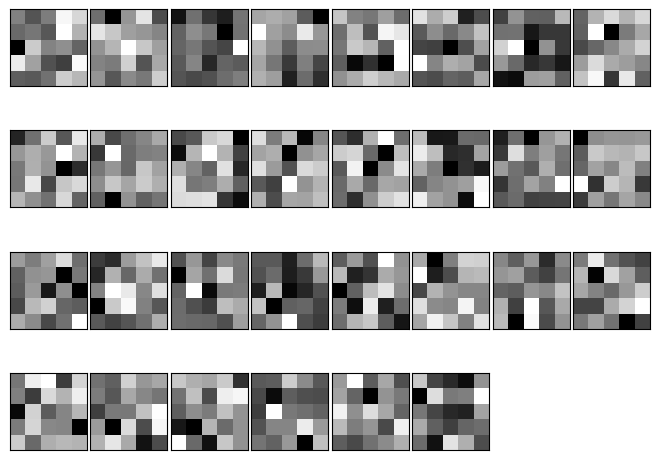

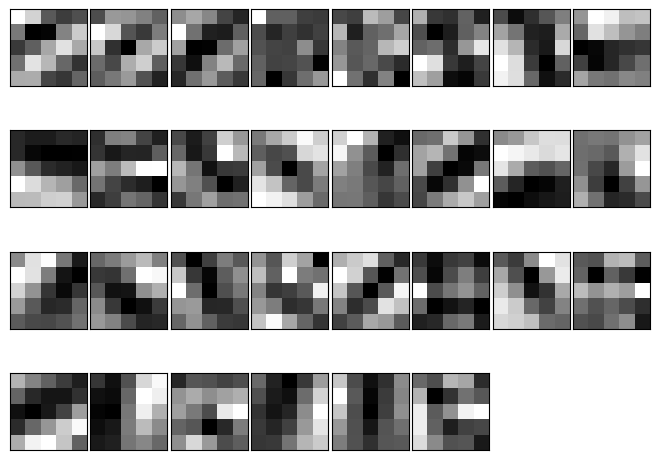

In [10]:
network = SimpleConvNet()
# ランダム初期化後の重み（フィルタ）でfilter_show
filter_show1(network.params['W1'])

network.load_params("../work/params.pkl")
# 学習後の重み（フィルタ）でfilter_show
filter_show1(network.params['W1'])

#### 学習したフィルタによる特徴マップ

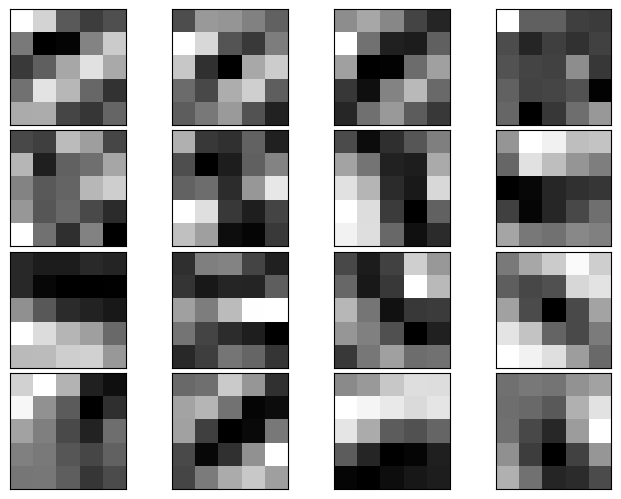

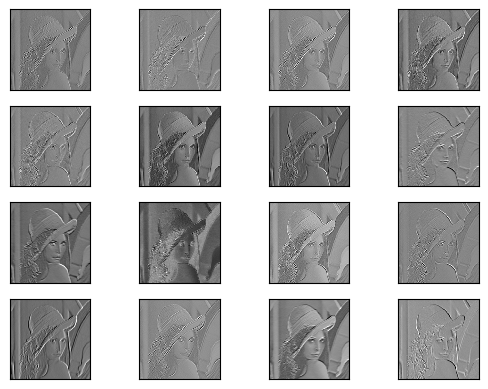

In [11]:
network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

# 学習後の重み（フィルタ）でfilter_show
network.load_params("../work/params.pkl")
filter_show2(network.params['W1'], 16)

# lena_gray.png
img = imread('./kasago/dataset/lena_gray.png')
img = img.reshape(1, 1, *img.shape)
fig = plt.figure()

w_idx = 1
for i in range(16):
    # 学習後の重み（フィルタ）
    w = network.params['W1'][i]
    b = 0  # network.params['b1'][i]
    w = w.reshape(1, *w.shape)
    #b = b.reshape(1, *b.shape)
    
    # 学習後の重み（フィルタ）で
    # lena_gray.pngの特徴マップを生成
    conv_layer = Convolution(w, b) 
    out = conv_layer.forward(img)
    out = out.reshape(out.shape[2], out.shape[3])
    
    # 特徴マップをsubplot
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    ax.imshow(out, cmap=plt.cm.gray_r, interpolation='nearest')

plt.show()